In [0]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4695380994641641226
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15431169210419847414
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
from google.colab import drive
drive.mount('/content/drive')
main_directory = '/content/drive/My Drive/Thesis/Thesis Codes 4_2/Dataset/train.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import drive

glove_dir = '/content/drive/My Drive/Thesis/Thesis Codes 4_2/Dataset/glove.twitter.27B.100d.txt'

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
nltk_stop_words = list(stopwords.words('english'))

In [0]:
dataset = pd.read_csv(main_directory,encoding = 'ISO-8859-1')
dataset.head()

,label,id,date,query,user,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [0]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,label,id,date,query,user,tweet
0,0,1975263232,Sat May 30 14:47:26 PDT 2009,NO_QUERY,rareinspiration,my facebook is going so slow....i think this s...
1,0,1983051829,Sun May 31 12:24:40 PDT 2009,NO_QUERY,arauser,Now I cant stop playing #ninjagaiden
2,4,1676849750,Fri May 01 23:26:15 PDT 2009,NO_QUERY,Muse4u2,@simplelight So much gratitude to you for you...
3,0,2175979480,Mon Jun 15 02:33:41 PDT 2009,NO_QUERY,ah8u,lying watching desperate housewives...feel lik...
4,4,1752701117,Sat May 09 22:42:03 PDT 2009,NO_QUERY,swong_,I'm enjoying this Sunday very much. No parents...


In [0]:
emotion = np.array(dataset['label'])

In [0]:
class_values = dataset['label'].unique()
print(class_values)

[0 4]


In [0]:
dataset.groupby('label')['tweet'].count()

label
0    799999
4    248576
Name: tweet, dtype: int64

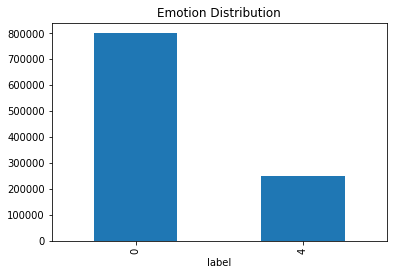

In [0]:
dataset.groupby('label')['tweet'].count().plot(kind='bar' , title= 'Emotion Distribution')

In [0]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('"?!,.():;')
    
    
    return word

In [0]:
def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)

In [0]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' smile ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' laugh ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' love ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' affection ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' sad ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' cry ', tweet)
    return tweet

In [0]:
def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()

    
    tweet = re.sub(r"what's", "what is ", tweet)
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"i'm", "i am ", tweet)
    tweet = re.sub(r"\'re", " are ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)

    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', ' ', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    #tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    # Striping numbers from the tweet
    tweet = re.sub(r'\d+', '', tweet)

    words = tweet.split()
    
    stemmer = SnowballStemmer('english')

    #Removing Stop Words and Stemming the Words
    for word in words:
        word = preprocess_word(word)
        if word not in nltk_stop_words and len(word)> 2:
            if is_valid_word(word):
                stemmed_words = stemmer.stem(word)
                processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [0]:
dataset['tweet'] = dataset['tweet'].map(lambda x: preprocess_tweet(x))
dataset.head()

,label,id,date,query,user,tweet
0,0,1975263232,Sat May 30 14:47:26 PDT 2009,NO_QUERY,rareinspiration,facebook going slow think skype slowing comput...
1,0,1983051829,Sun May 31 12:24:40 PDT 2009,NO_QUERY,arauser,cant stop playing ninjagaiden
2,4,1676849750,Fri May 01 23:26:15 PDT 2009,NO_QUERY,Muse4u2,much gratitude wonderful inspiration student k...
3,0,2175979480,Mon Jun 15 02:33:41 PDT 2009,NO_QUERY,ah8u,lying watching desperate housewives feel like ...
4,4,1752701117,Sat May 09 22:42:03 PDT 2009,NO_QUERY,swong_,enjoying sunday much parents revision like sunday


In [0]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [0]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

[0 4]


In [0]:
vocabulary_size = 10000
input_length = 100

In [0]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['tweet'])
sequences = tokenizer.texts_to_sequences(dataset['tweet'])
data = pad_sequences(sequences, maxlen = input_length)

In [0]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [0]:
num_classes = len(class_values)
validation_split = 0.1

**Stacked LSTM with 1D Convolution**

In [0]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 5

pool_size = 4

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [0]:
model_conv = Sequential()

model_conv.add(Embedding(vocabulary_size, output_dim, input_length = input_length, trainable=False))
model_conv.add(Dropout(dropout))
#model_conv.add(Dense(output_dim, activation='tanh'))

model_conv.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, activation = 'relu'))
model_conv.add(MaxPooling1D(pool_size = pool_size))

model_conv.add(LSTM(l1_lstm_units , dropout = l1_dropout, return_sequences=True, activation='tanh'))
model_conv.add(LSTM(l2_lstm_units , dropout = l2_dropout, return_sequences=False, activation='relu'))

model_conv.add(Dense(num_classes, activation='softmax'))
model_conv.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model_conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 100)           50100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 24, 64)            42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 2)                 6

In [0]:
epochs = 3

In [0]:
callback_patience = 2

In [0]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 754974 samples, validate on 83886 samples
Epoch 1/3
754974/754974 [==============================] - 1815s 2ms/sample - loss: 0.4797 - acc: 0.7843 - val_loss: 0.4534 - val_acc: 0.8013
Epoch 2/3
754974/754974 [==============================] - 1831s 2ms/sample - loss: 0.4468 - acc: 0.7973 - val_loss: 0.4302 - val_acc: 0.8074
Epoch 3/3
754974/754974 [==============================] - 1827s 2ms/sample - loss: 0.4373 - acc: 0.8019 - val_loss: 0.4241 - val_acc: 0.8082


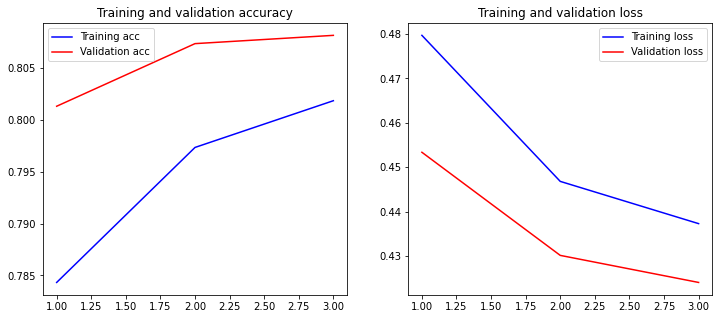

In [0]:
history = model_conv.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                         shuffle = True, callbacks = callback)

plot_model(history)

In [0]:
model_conv.evaluate(test_data, test_label, verbose = 1)

209715/209715 [==============================] - 118s 562us/sample - loss: 0.4241 - acc: 0.8095


[0.4240569803019727, 0.80947953]

In [0]:

model_conv.save('saved_model\model_conv.h5')

In [0]:
predictions = model_conv.predict(test_data, verbose=1)
print(predictions[:, 0])

209715/209715 [==============================] - 115s 550us/sample
[0.72919965 0.06805678 0.89835626 ... 0.6257947  0.6991164  0.96217686]


In [0]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test_data,predictions)

ValueError: ignored

In [0]:
test_text = 'I was happy'
test_text = pd.Series(test_text)

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

In [0]:
label_encoder.classes_[np.argmax(model_conv.predict(data))]

4

In [0]:
print(label_encoder.classes_)

[0 4]


In [0]:
np.around(model_conv.predict(data), decimals = 2)

array([[0.12, 0.88]], dtype=float32)